# Model Predictive Control

In [1]:
import sqlite3
from calliope.data import DataManager
from calliope.market import MeritOrderNEM
import pandas as pd
import datetime

con = sqlite3.connect('E:/Code/Calliope/notebooks/historical_mms.db')
start_date = '2019/07/01 00:00:00'
end_date = '2019/09/01 00:00:00'
region = 'NSW1'


print('Loading data')
data_manager = DataManager(con)
data_manager.load_data(start_date, end_date, region, nem_solve_data=True)
nem = MeritOrderNEM(data_manager)
nem.build()

nem.load_bids_from_pickle(
    [f'E:/Code/Calliope/notebooks/bid_dict_{i}_nsw.pkl' for i in ['jul','aug']]
)

Loading data


In [39]:
start_date = '2019/07/01 00:00:00'
end_date = '2019/09/01 00:00:00'
from calliope.optimisation import config, mip_joint_simple, base
from calliope import mpc
from calliope.prices import construct_prices_from_merit_order_csv, construct_prices_from_dict
prices = construct_prices_from_merit_order_csv(
    path='E:/Code/Calliope/notebooks/merit_order_prices.csv', 
    region_id= 'NSW1', 
    start_date = start_date,
    end_date = end_date,
    create_agc=True
)
bess_config = config.load_config('E:/Code\Calliope/scripts/config.yml')


In [41]:
import sqlite3
from calliope.data import DataManager
from calliope.market import MeritOrderNEM
import pandas as pd
import datetime

con = sqlite3.connect('E:/Code/Calliope/notebooks/historical_mms.db')
start_date = '2019/07/01 00:00:00'
end_date = '2019/09/01 00:00:00'
region = 'NSW1'


print('Loading data')
data_manager = DataManager(con)
data_manager.load_data(start_date, end_date, region, nem_solve_data=True)
nem = MeritOrderNEM(data_manager)
nem.build()

nem.load_bids_from_pickle(
    [f'E:/Code/Calliope/notebooks/bid_dict_{i}_nsw.pkl' for i in ['jul','aug']]
)

from calliope.optimisation import config, mip_joint_simple
from calliope import mpc
from calliope.optimisation import mip_joint_gurobi

from calliope.prices import construct_prices_from_merit_order_csv
prices = construct_prices_from_merit_order_csv(
    path='E:/Code/Calliope/notebooks/merit_order_prices.csv', 
    region_id= 'NSW1', 
    start_date = start_date,
    end_date = end_date,
    create_agc=True
)
bess_config = config.load_config('E:/Code\Calliope/scripts/config.yml')

model = mip_joint_gurobi.MIPJointBESSGurobi(bess_config)

# This can be replaced with mip_joint_simple if you don't have gurobi, it'll just take way longer
model_no_gurobi = mip_joint_simple.MixedIntegerESSModelJoint(bess_config, solver_backend='SCIP')


import pickle
with open('lstm_price_predictions.pkl', 'rb') as f:
    lstm_price_predictions = pickle.load(f)

results=mpc.run_bess_mpc_simulation(model, prices, nem, horizon=288, price_forecasts=lstm_price_predictions)
revenues = mpc.calculate_simulation_cumulative_revenue(results)

# Results

In [44]:
start_datetime = datetime.datetime.strptime(start_date, '%Y/%m/%d %H:%M:%S')
end_datetime = datetime.datetime.strptime(end_date, '%Y/%m/%d %H:%M:%S')

start_date_save_str = f'{start_datetime.month}_{start_datetime.day}'
end_date_save_str= f'{end_datetime.month}_{end_datetime.day}'
last_soc = results.tail(2).head(1).SOC.iloc[0]

In [45]:
results.to_csv(f'mpc_pt_predlstm_{start_date_save_str}_{end_date_save_str}_results.csv', index=False)

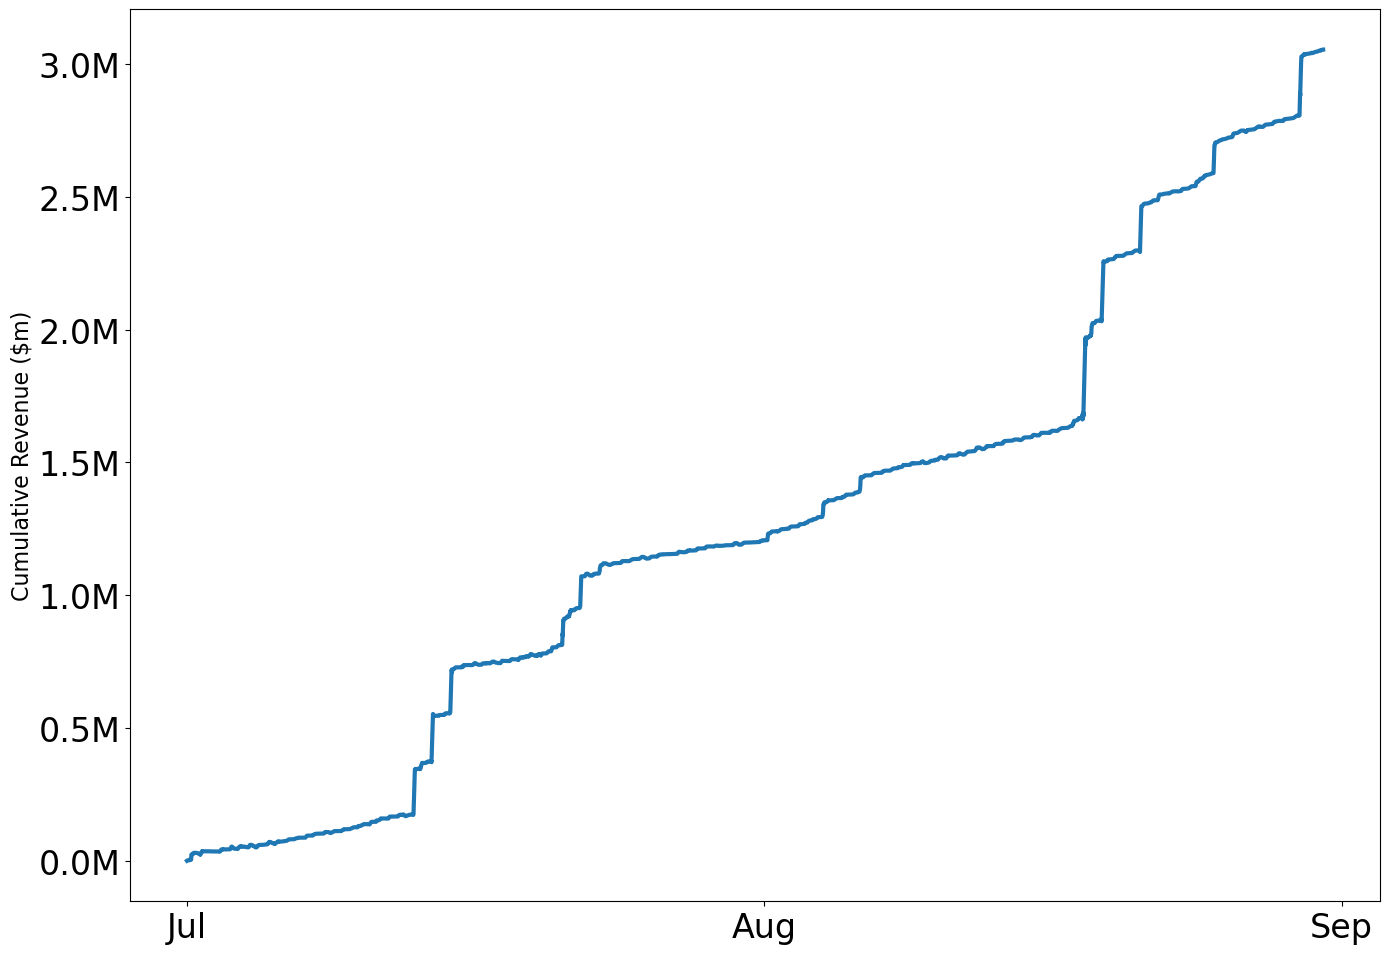

In [46]:
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)

fig, ax = plt.subplots(figsize=(14,10))

ax.plot(revenues.SETTLEMENTDATE, revenues.TOTAL, label='Energy', linewidth =3)

# ax2 = ax.twinx()

# ax2.plot(results_df.SETTLEMENTDATE, results_df.ENERGY_price, color='r', alpha=0.3, label='Energy Price')
# ax.set_xlabel('SETTLEMENTDATE', fontsize=16)
ax.set_ylabel('Cumulative Revenue ($m)', fontsize=16)
# ax.set_ylabel('Energy Price ($/MWh)', fontsize=24)

ax.xaxis.set_major_locator(mdates.MonthLocator([7,8,9]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)
ax.yaxis.set_major_formatter(formatter)
# ax2.yaxis.set_tick_params(labelsize=16)


# ax.spines["top"].set_visible(False)
# ax2.spines["top"].set_visible(False)

fig.tight_layout()
# fig.suptitle("Price-Maker Energy-Reg Bidding Cumulative Revenue Jul-Aug", size=20)
fig.subplots_adjust(top=0.95)
# fig.legend(fontsize=24)

In [47]:
fig.savefig('mpc_predlstm_price_taker_cumulative_revenues.png', bbox_inches='tight', dpi=250)